In [1]:
# General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
import xgboost as xgb

# Deep Learning (LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

# Metrics for Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Time Series Analysis
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


In [2]:
all_data_daily_path = 'merged_data_granualityBased/_data_(daily).csv'

In [3]:
all_data_daily = pd.read_csv(all_data_daily_path)

In [4]:
all_data_daily.head()

,date,loadConsumption,DailyPrecipitation,MaxHourlyPrecipitation,DailyMeanTemperature,HourlyMinTemperature,HourlyMaxTemperature,DailyMeanWindspeed,MaxHourlyMeanWindspeed,MinHourlyMeanWindspeed,...,TotalBiomass (MWh),TotalRes(incl.Stat.Transfer) (MWh),Totaal windenergie (MWh),TotalSolarEnergy (MWh),Total Including Non-Renewable (MWh),AveragePrice_Electricity_Household,AveragePrice_Electricity_NonHousehold,AveragePrice_NaturalGas_Household,AveragePrice_NaturalGas_NonHousehold,GDP
0,2015-01-01,275667.0,-0.1,-0.1,3.0,10,4.7,5.4,8.0,4.0,...,21863230.46,32553593.76,6916722.0,1424178.06,5.684820e+08,0.1604,0.122143,0.818667,0.4962,171938.0
1,2015-01-02,319026.0,4.3,1.7,7.3,44,10.1,6.1,9.0,4.0,...,21863230.46,32553593.76,6916722.0,1424178.06,5.684820e+08,0.1604,0.122143,0.818667,0.4962,171938.0
2,2015-01-03,313131.0,1.5,0.5,3.8,26,5.9,3.3,5.0,1.0,...,21863230.46,32553593.76,6916722.0,1424178.06,5.684820e+08,0.1604,0.122143,0.818667,0.4962,171938.0
3,2015-01-04,296832.0,-0.1,-0.1,3.9,-3,8.0,2.4,3.0,2.0,...,21863230.46,32553593.76,6916722.0,1424178.06,5.684820e+08,0.1604,0.122143,0.818667,0.4962,171938.0
4,2015-01-05,350937.0,0.0,0.0,2.4,9,3.8,3.0,5.0,1.0,...,21863230.46,32553593.76,6916722.0,1424178.06,5.684820e+08,0.1604,0.122143,0.818667,0.4962,171938.0


### Stationary Check

In [5]:
# Check for stationarity using Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Data is stationary")
    else:
        print("Data is NOT stationary")

In [6]:
adf_test(all_data_daily["loadConsumption"])

ADF Statistic: -3.883797974869571
p-value: 0.002157374063032164
Data is stationary


In [7]:
data = all_data_daily.copy()

In [8]:
data["date"] = pd.to_datetime(data["date"])

In [9]:
data.isna().sum()

date                                     0
loadConsumption                          0
DailyPrecipitation                       0
MaxHourlyPrecipitation                   0
DailyMeanTemperature                     0
HourlyMinTemperature                     0
HourlyMaxTemperature                     0
DailyMeanWindspeed                       0
MaxHourlyMeanWindspeed                   0
MinHourlyMeanWindspeed                   0
Month                                    0
Year                                     0
Week                                     0
day_of_week                              0
Population                               0
TotalBiomass (MWh)                       0
TotalRes(incl.Stat.Transfer) (MWh)       0
Totaal windenergie (MWh)                 0
TotalSolarEnergy (MWh)                   0
Total Including Non-Renewable (MWh)      0
AveragePrice_Electricity_Household       0
AveragePrice_Electricity_NonHousehold    0
AveragePrice_NaturalGas_Household        0
AveragePric

### Correlation Matrix of Electricity Load and Explanatory Variables

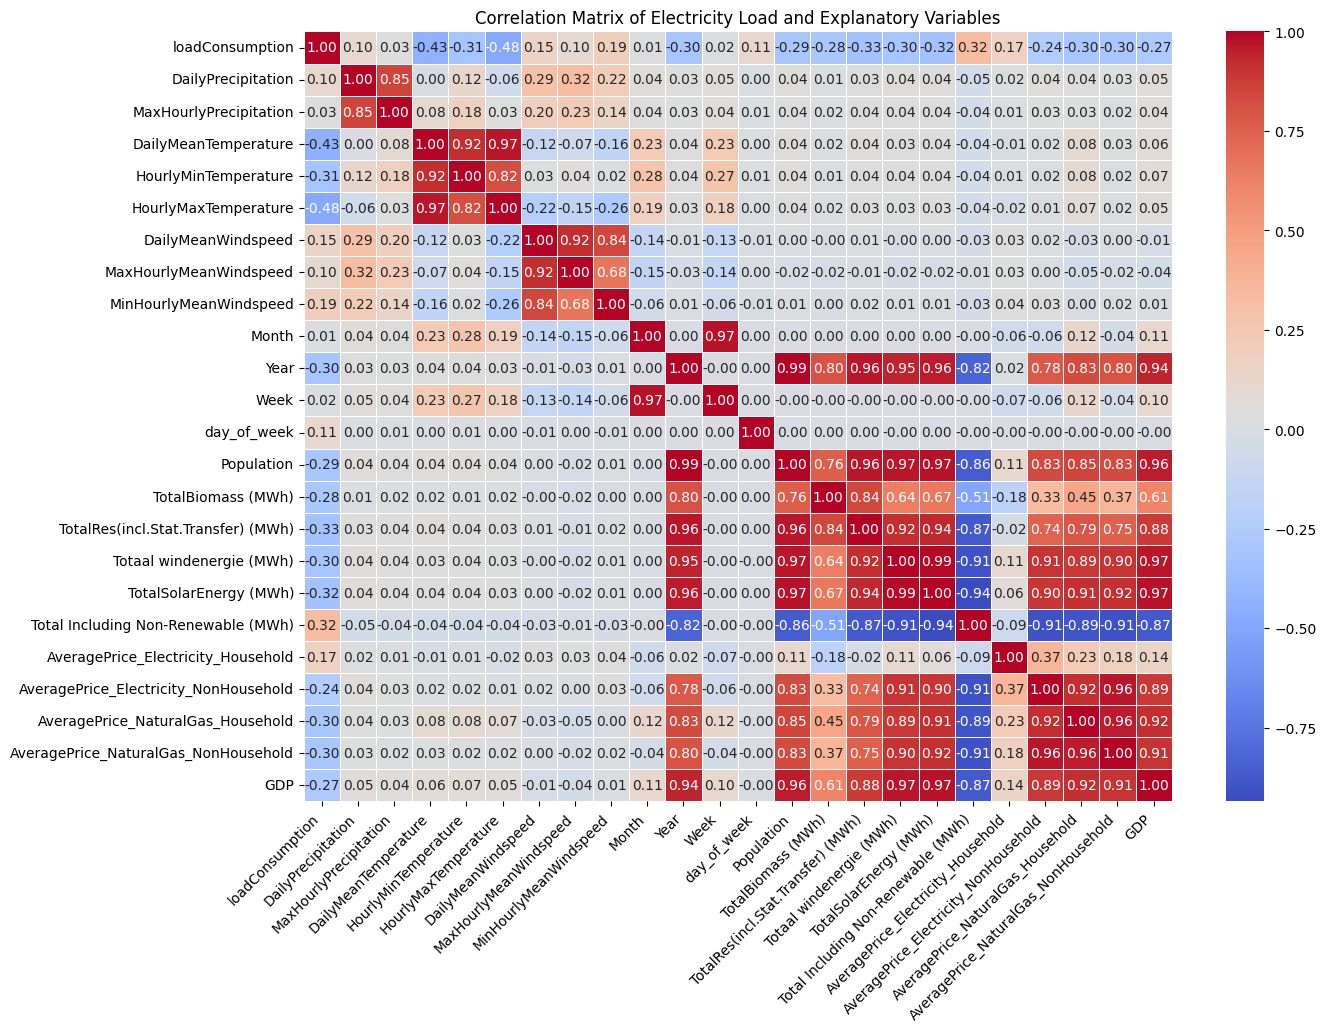

In [10]:
numeric_cols = data.select_dtypes(include=["number"])

# Compute correlation matrix
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(14, 10))  
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Electricity Load and Explanatory Variables")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.yticks(rotation=0)  
plt.show()

### VIF analysis

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only numeric features for VIF analysis
numeric_features = data.select_dtypes(include=[np.number]).dropna()

# Compute Variance Inflation Factor (VIF) for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_features.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_features.values, i) for i in range(numeric_features.shape[1])]

In [12]:
vif_data

,Feature,VIF
0,loadConsumption,1.813014e+00
1,DailyPrecipitation,4.036894e+00
2,MaxHourlyPrecipitation,3.804269e+00
3,DailyMeanTemperature,9.301182e+01
4,HourlyMinTemperature,1.839412e+01
5,HourlyMaxTemperature,4.486795e+01
6,DailyMeanWindspeed,1.589093e+01
7,MaxHourlyMeanWindspeed,8.474090e+00
8,MinHourlyMeanWindspeed,4.656141e+00
9,Month,2.192828e+01


### Stepwise Selection

In [13]:
# Define target variable (y) and features (X)
target_variable = "loadConsumption" 

# Separate features and target
X = data.drop(columns=[target_variable])
y = data[target_variable]

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display dataset shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2629, 24), (658, 24), (2629,), (658,))

In [14]:
X_train = X_train.drop(columns=['date'])
X_test = X_test.drop(columns=['date'])

In [15]:
import statsmodels.api as sm

def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.10):
    initial_features = X.columns.tolist()
    selected_features = []
    
    while True:
        changed = False
        
        # Forward Selection
        remaining_features = list(set(initial_features) - set(selected_features))
        new_pval = pd.Series(index=remaining_features, dtype=float)
        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[selected_features + [feature]])).fit()
            new_pval[feature] = model.pvalues[feature]

        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            selected_features.append(best_feature)
            changed = True
        
        # Backward Elimination
        model = sm.OLS(y, sm.add_constant(X[selected_features])).fit()
        pvalues = model.pvalues.iloc[1:]  # Ignore intercept
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            selected_features.remove(worst_feature)
            changed = True
        
        if not changed:
            break

    return selected_features

# Run stepwise selection
selected_features = stepwise_selection(X_train, y_train)
print("Selected Features:", selected_features)

Selected Features: ['HourlyMaxTemperature', 'AveragePrice_Electricity_Household', 'HourlyMinTemperature', 'day_of_week', 'AveragePrice_NaturalGas_NonHousehold', 'GDP', 'TotalBiomass (MWh)', 'Totaal windenergie (MWh)', 'DailyPrecipitation', 'Population']


### Generate features

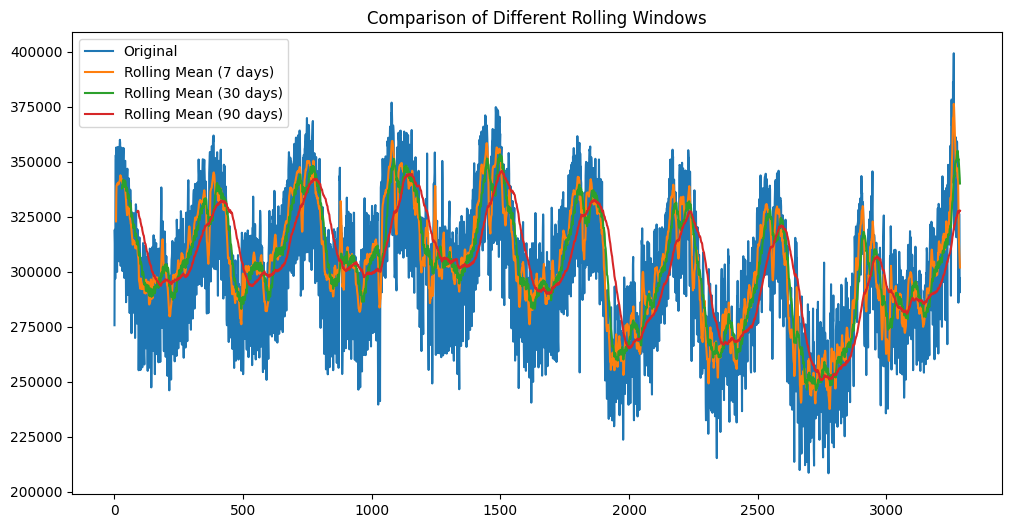

In [16]:
plt.figure(figsize=(12,6))
plt.plot(data['loadConsumption'], label='Original')
plt.plot(data['loadConsumption'].rolling(window=7).mean(), label='Rolling Mean (7 days)')
plt.plot(data['loadConsumption'].rolling(window=30).mean(), label='Rolling Mean (30 days)')
plt.plot(data['loadConsumption'].rolling(window=90).mean(), label='Rolling Mean (90 days)')
plt.legend()
plt.title('Comparison of Different Rolling Windows')
# Save the plot with better quality
plt.savefig("plots/rolling_mean_comparison.png", dpi=300, bbox_inches='tight', transparent=False)

# Show the plot
plt.show()

In [17]:
from pandas.tseries.holiday import USFederalHolidayCalendar  # Adjust based on your region

def create_time_features(data, target_column='loadConsumption'):
    """
    Generate time-based features for time series forecasting.
    
    Parameters:
    - data (DataFrame): The original dataset containing a 'date' column.
    - target_column (str): The target variable for rolling features.
    
    Returns:
    - data (DataFrame): The updated DataFrame with new features.
    """

    # Ensure 'date' is a datetime index
    data['date'] = pd.to_datetime(data['date'])
    data = data.set_index('date')

    # Create 'is_weekend' feature (1 if Saturday/Sunday, else 0)
    data['is_weekend'] = data.index.weekday.isin([5, 6]).astype(int)

    # Create 'is_holiday' feature (1 if a holiday, else 0)
    cal = USFederalHolidayCalendar()  # You can replace with a different holiday calendar
    holidays = cal.holidays(start=data.index.min(), end=data.index.max())
    data['is_holiday'] = data.index.isin(holidays).astype(int)

    # Create 'day_of_year' feature 
    data['day_of_year'] = data.index.dayofyear.astype(int)

    # Create rolling mean features for the target variable
    data['rolling_7'] = data[target_column].rolling(window=7, min_periods=1).mean()
    data['rolling_30'] = data[target_column].rolling(window=30, min_periods=1).mean()
    data['rolling_365'] = data[target_column].rolling(window=365, min_periods=1).mean()

    return data

In [18]:
data = create_time_features(data)

In [19]:
selected_coloumns = ['HourlyMaxTemperature', 'AveragePrice_Electricity_Household', 'HourlyMinTemperature', 'day_of_week', 'AveragePrice_NaturalGas_NonHousehold',
                     'GDP', 'TotalSolarEnergy (MWh)', 'Totaal windenergie (MWh)',
                     'DailyPrecipitation', 'Population', 'is_weekend', 'is_holiday', 'day_of_year', 'rolling_7', 'rolling_30', 'loadConsumption'] 

In [20]:
df_models = data[selected_coloumns]

#### Features

In [21]:
feature_sets = {
    "Exogenous Features": [
        'HourlyMaxTemperature',
        'AveragePrice_Electricity_Household',
        'HourlyMinTemperature',
        'day_of_week',
        'AveragePrice_NaturalGas_NonHousehold',
        'GDP',
        'TotalSolarEnergy (MWh)',
        'Totaal windenergie (MWh)',
        'DailyPrecipitation',
        'Population'
    ],
    "Generated Features": [
        'is_weekend',
        'is_holiday',
        'day_of_year',
        'rolling_7',
        'rolling_30'
    ],
    "Both Exogenous & Generated": [
        'HourlyMaxTemperature',
        'AveragePrice_Electricity_Household',
        'HourlyMinTemperature',
        'day_of_week',
        'AveragePrice_NaturalGas_NonHousehold',
        'GDP',
        'TotalSolarEnergy (MWh)',
        'Totaal windenergie (MWh)',
        'DailyPrecipitation',
        'Population',
        'is_weekend',
        'is_holiday',
        'day_of_year',
        'rolling_7',
        'rolling_30'
    ]
}

## Test with different models

### SARIMAX| BASELINE

##### Autocorrelation Function (ACF) & Partial Autocorrelation Function (PACF)

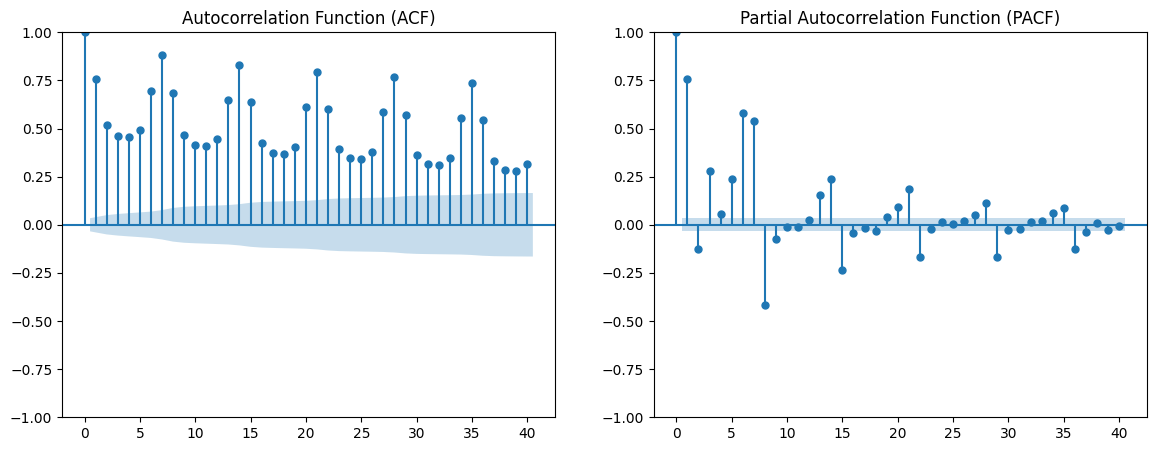

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ensure date is in datetime format and set as index
all_data_daily['date'] = pd.to_datetime(all_data_daily['date'])
all_data_daily.set_index('date', inplace=True)

# Extract the target variable for ARIMA
load_consumption = all_data_daily['loadConsumption']

# Plot ACF and PACF to determine ARIMA parameters
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot
plot_acf(load_consumption, ax=ax[0], lags=40)
ax[0].set_title("Autocorrelation Function (ACF)")

# PACF plot
plot_pacf(load_consumption, ax=ax[1], lags=40)
ax[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

In [23]:
df_sarimax = df_models

In [24]:
df_sarimax.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3287 entries, 2015-01-01 to 2023-12-31
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   HourlyMaxTemperature                  3287 non-null   float64
 1   AveragePrice_Electricity_Household    3287 non-null   float64
 2   HourlyMinTemperature                  3287 non-null   int64  
 3   day_of_week                           3287 non-null   int64  
 4   AveragePrice_NaturalGas_NonHousehold  3287 non-null   float64
 5   GDP                                   3287 non-null   float64
 6   TotalSolarEnergy (MWh)                3287 non-null   float64
 7   Totaal windenergie (MWh)              3287 non-null   float64
 8   DailyPrecipitation                    3287 non-null   float64
 9   Population                            3287 non-null   float64
 10  is_weekend                            3287 non-null   int32  
 11 

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def run_sarimax(train_df, test_df, feature_sets, target_col='loadConsumption',
                order=(1,1,1), seasonal_order=(0,0,0,0)):
    """
    Trains and evaluates SARIMAX on multiple feature sets, returning a DataFrame of metrics.
    """
    results = []
    
    for fs_name, fs_columns in feature_sets.items():
        y_train = train_df[target_col]
        y_test = test_df[target_col]
        X_train = train_df[fs_columns]
        X_test = test_df[fs_columns]
        
        # Fit SARIMAX
        sarimax_model = SARIMAX(
            endog=y_train,
            exog=X_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        
        # Predict or forecast
        start_idx = len(y_train)
        end_idx = start_idx + len(y_test) - 1
        y_pred = sarimax_model.predict(start=start_idx, end=end_idx, exog=X_test)
        
        # Compute metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Feature Set': fs_name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })
    
    return pd.DataFrame(results)


In [26]:
train_df, test_df = train_test_split(df_models, test_size=0.2, shuffle=False)

In [27]:
sarimax_results_df = run_sarimax(
    train_df, 
    test_df, 
    feature_sets, 
    target_col='loadConsumption',
    order=(2,0,3), 
    seasonal_order=(1,0,1,7)
)
sarimax_results_df

C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mahmo\AppData\Local\Programs\Py

,Feature Set,MSE,RMSE,MAE,R2
0,Exogenous Features,2.622820e+09,51213.470853,41688.090079,-1.458924
1,Generated Features,1.253719e+08,11196.960504,8608.474107,0.882462
2,Both Exogenous & Generated,1.281507e+08,11320.367879,8919.318897,0.879857


In [28]:
def run_sklearn_model(regressor, train_df, test_df, feature_sets, target_col='loadConsumption'):
    """
    Trains and evaluates a given scikit-learn regressor on multiple feature sets.
    Returns a DataFrame of metrics for each feature set.
    """
    results = []
    
    for fs_name, fs_columns in feature_sets.items():
        X_train = train_df[fs_columns]
        y_train = train_df[target_col]
        X_test = test_df[fs_columns]
        y_test = test_df[target_col]
        
        # Fit the model
        regressor.fit(X_train, y_train)
        # Predict
        y_pred = regressor.predict(X_test)
        
        # Compute metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Feature Set': fs_name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })
    
    # Convert to DataFrame
    return pd.DataFrame(results)


#### linear regression

In [29]:
lr_model = LinearRegression()
lr_results_df = run_sklearn_model(lr_model, train_df, test_df, feature_sets)
lr_results_df

,Feature Set,MSE,RMSE,MAE,R2
0,Exogenous Features,1.484790e+09,38532.975173,31795.613547,-0.392008
1,Generated Features,1.310771e+08,11448.889449,8861.075844,0.877114
2,Both Exogenous & Generated,1.269543e+08,11267.398172,8859.009689,0.880979


#### radom forest

In [30]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_results_df = run_sklearn_model(rf_model, train_df, test_df, feature_sets, target_col='loadConsumption')
rf_results_df

,Feature Set,MSE,RMSE,MAE,R2
0,Exogenous Features,4.896337e+08,22127.668929,18050.952252,0.540963
1,Generated Features,1.620436e+08,12729.635260,9830.252555,0.848082
2,Both Exogenous & Generated,1.296962e+08,11388.425718,8766.946939,0.878408


#### ensemble model

In [31]:
ensemble_model = VotingRegressor(
    estimators=[
        ('lr', LinearRegression()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('xgb', XGBRegressor(n_estimators=50, learning_rate=0.1, random_state=42))
    ]
)

ensemble_results_df = run_sklearn_model(ensemble_model, train_df, test_df, feature_sets)
ensemble_results_df

,Feature Set,MSE,RMSE,MAE,R2
0,Exogenous Features,5.411236e+08,23262.064337,18990.127956,0.492690
1,Generated Features,1.340615e+08,11578.490863,9008.645227,0.874316
2,Both Exogenous & Generated,1.079855e+08,10391.606910,8093.899552,0.898762


#### XGBoost

In [32]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_results_df = run_sklearn_model(xgb_model, train_df, test_df, feature_sets)
xgb_results_df


,Feature Set,MSE,RMSE,MAE,R2
0,Exogenous Features,5.049021e+08,22470.026378,18068.697439,0.526648
1,Generated Features,1.657578e+08,12874.696813,9949.315679,0.844600
2,Both Exogenous & Generated,1.260592e+08,11227.608717,8860.043195,0.881818


#### lstm

In [68]:
train_df = df_models.loc[:'2022-12-31']
test_df = df_models.loc['2023-01-01':]

# 2) The target column for the LSTM
target_col = 'loadConsumption'

###############################################################################
# Helper Function 1: create_sequences
###############################################################################
def create_sequences(X, y, time_steps=10):
    """
    Converts 2D arrays (X) and 1D arrays (y) into 3D LSTM-friendly sequences
    (num_samples, time_steps, num_features) and a 1D array of targets (num_samples,).
    
    time_steps: number of past observations to use for each sequence
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i : i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

###############################################################################
# Helper Function 2: build_lstm_model
###############################################################################
def build_lstm_model(n_timesteps, n_features):
    """
    Creates and compiles an LSTM model with two layers + dropouts.
    Adjust units, layers, activation, etc. to suit your data.
    """
    model = Sequential()
    # First LSTM layer
    model.add(LSTM(100, activation='relu', return_sequences=True, 
                   input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    
    # Final output layer (1 unit for a regression task)
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse')
    return model

###############################################################################
# Step C: Loop Over Feature Sets
###############################################################################
all_results = []  # Will store metrics for each feature set

# The number of time steps in each sliding window
time_steps = 10

for fs_name, fs_columns in feature_sets.items():
    print(f"\n=== Training LSTM for feature set: {fs_name} ===")
    
    # 1) Slice out the columns from train/test
    train_X = train_df[fs_columns].values
    test_X = test_df[fs_columns].values
    
    # 2) Slice out the target
    train_y = train_df[target_col].values
    test_y = test_df[target_col].values
    
    # 3) Scale the features (optional but recommended for LSTM)
    scaler_X = MinMaxScaler()
    scaler_X.fit(train_X)  # fit only on train data
    train_X_scaled = scaler_X.transform(train_X)
    test_X_scaled  = scaler_X.transform(test_X)
    
    # Optionally, scale the target as well
    scaler_y = MinMaxScaler()
    train_y_reshaped = train_y.reshape(-1, 1)
    scaler_y.fit(train_y_reshaped)
    train_y_scaled = scaler_y.transform(train_y_reshaped).ravel()
    test_y_scaled  = scaler_y.transform(test_y.reshape(-1, 1)).ravel()
    
    # 4) Create LSTM sequences for train/test
    X_train_seq, y_train_seq = create_sequences(train_X_scaled, train_y_scaled, time_steps=time_steps)
    X_test_seq,  y_test_seq  = create_sequences(test_X_scaled,  test_y_scaled,  time_steps=time_steps)
    
    # Check shapes
    if X_train_seq.shape[0] == 0 or X_test_seq.shape[0] == 0:
        print("Not enough data to create sequences. Skipping this feature set.")
        all_results.append({
            'Feature Set': fs_name,
            'MSE':  np.nan,
            'RMSE': np.nan,
            'MAE':  np.nan,
            'R^2':  np.nan
        })
        continue
    
    n_features = len(fs_columns)  # number of columns in this set
    
    # 5) Build and train the model
    lstm_model = build_lstm_model(time_steps, n_features)
    
    # You can add callbacks like EarlyStopping if you want
    history = lstm_model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=32,
        validation_data=(X_test_seq, y_test_seq),
        verbose=1
    )
    
    # 6) Evaluate the model on the test set
    y_pred_scaled = lstm_model.predict(X_test_seq).ravel()
    
    # Inverse-transform predictions and test values back to original scale
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
    
    # The test values also need to be trimmed for the sequences
    # Actually, y_test_seq was already scaled. Let's inverse it:
    y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1,1)).ravel()
    
    # 7) Compute metrics
    mse = mean_squared_error(y_test_actual, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)
    
    # 8) Store metrics
    all_results.append({
        'Feature Set': fs_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R^2': r2
    })

# Convert the aggregated results into a DataFrame
results_df = pd.DataFrame(all_results)
print("\n=== LSTM Results Across Feature Sets ===")
results_df


=== Training LSTM for feature set: Exogenous Features ===
Epoch 1/50
91/91 [==============================] - 3s 15ms/step - loss: 0.0554 - val_loss: 0.0894
Epoch 2/50
91/91 [==============================] - 1s 12ms/step - loss: 0.0263 - val_loss: 0.0323
Epoch 3/50
91/91 [==============================] - 1s 12ms/step - loss: 0.0229 - val_loss: 0.0390
Epoch 4/50
91/91 [==============================] - 1s 13ms/step - loss: 0.0192 - val_loss: 0.0371
Epoch 5/50
91/91 [==============================] - 1s 16ms/step - loss: 0.0172 - val_loss: 0.0354
Epoch 6/50
91/91 [==============================] - 1s 16ms/step - loss: 0.0158 - val_loss: 0.0344
Epoch 7/50
91/91 [==============================] - 2s 17ms/step - loss: 0.0152 - val_loss: 0.0391
Epoch 8/50
91/91 [==============================] - 1s 16ms/step - loss: 0.0142 - val_loss: 0.0406
Epoch 9/50
91/91 [==============================] - 1s 16ms/step - loss: 0.0136 - val_loss: 0.0382
Epoch 10/50
91/91 [==============================]

,Feature Set,MSE,RMSE,MAE,R^2
0,Exogenous Features,9.840997e+08,31370.363424,25697.946127,-0.199283
1,Generated Features,1.846728e+08,13589.438115,10353.229854,0.774947
2,Both Exogenous & Generated,9.541251e+08,30888.915490,26808.593271,-0.162754


In [75]:
from tensorflow.keras.optimizers import Adam

Epoch 1/50
163/163 [==============================] - 18s 64ms/step - loss: 0.5085 - val_loss: 1.3450
Epoch 2/50
163/163 [==============================] - 10s 63ms/step - loss: 0.3661 - val_loss: 0.9995
Epoch 3/50
163/163 [==============================] - 11s 65ms/step - loss: 0.2242 - val_loss: 0.5655
Epoch 4/50
163/163 [==============================] - 14s 85ms/step - loss: 0.1730 - val_loss: 0.3316
Epoch 5/50
163/163 [==============================] - 16s 96ms/step - loss: 0.1436 - val_loss: 0.3514
Epoch 6/50
163/163 [==============================] - 16s 100ms/step - loss: 0.1309 - val_loss: 0.6450
Epoch 7/50
163/163 [==============================] - 14s 85ms/step - loss: 0.1281 - val_loss: 0.8185
Epoch 8/50
163/163 [==============================] - 15s 95ms/step - loss: 0.1236 - val_loss: 1.1347
Epoch 9/50
163/163 [==============================] - 16s 98ms/step - loss: 0.1179 - val_loss: 0.8092
Epoch 10/50
163/163 [==============================] - 14s 86ms/step - loss: 0.11

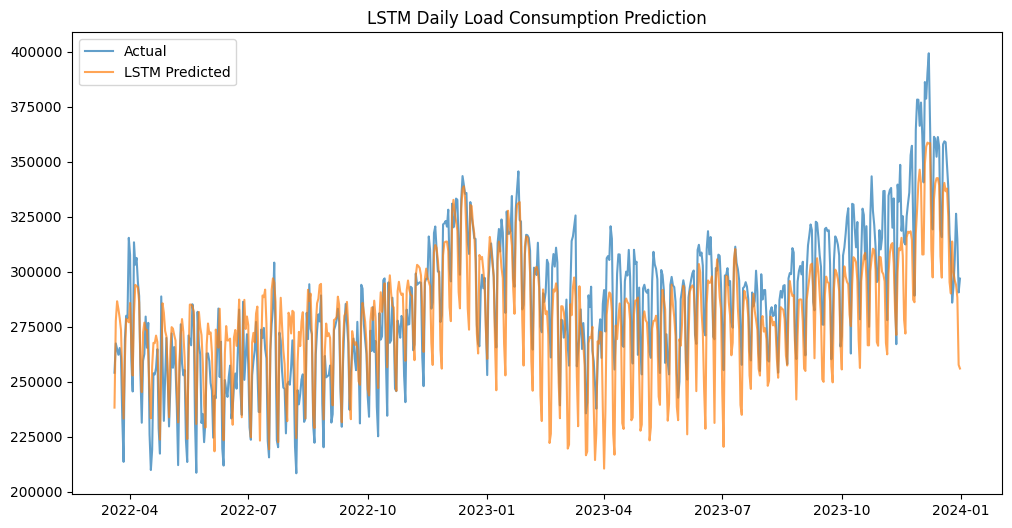

In [78]:
# Define LSTM Data Preparation Function
def prepare_lstm_data(data, target_column, lookback=30):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data.iloc[i-lookback:i].values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)

# Select Features and Target
daily_features = df_models.drop(columns=["loadConsumption"])
daily_target = "loadConsumption"

# Identify and drop any datetime columns
datetime_cols = daily_features.select_dtypes(include=['datetime64']).columns
daily_features = daily_features.drop(columns=datetime_cols)

# Scale features
scaler_features = StandardScaler()
daily_features_scaled = scaler_features.fit_transform(daily_features)

# Scale target separately
scaler_target = StandardScaler()
daily_target_scaled = scaler_target.fit_transform(df_models[["loadConsumption"]])

# Combine features and target into a DataFrame
daily_scaled_df = pd.DataFrame(daily_features_scaled, index=df_models.index, columns=daily_features.columns)
daily_scaled_df["loadConsumption"] = daily_target_scaled  # Add target back


# Prepare LSTM Data
lookback = 30  # Use past 30 days to predict next day
X_lstm, y_lstm = prepare_lstm_data(daily_scaled_df, "loadConsumption", lookback)

# Split Data into Train and Test
split_index = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_index], X_lstm[split_index:]
y_train_lstm, y_test_lstm = y_lstm[:split_index], y_lstm[split_index:]

# Define LSTM Model
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(lookback, X_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Compile Model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train Model
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, validation_data=(X_test_lstm, y_test_lstm))

# Predict
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Rescale Predictions
y_pred_lstm = scaler_target.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_test_lstm = scaler_target.inverse_transform(y_test_lstm.reshape(-1, 1))

# Evaluate Model
print("LSTM Model Performance:")
print(f"MAE: {mean_absolute_error(y_test_lstm, y_pred_lstm)}, MSE: {mean_squared_error(y_test_lstm, y_pred_lstm)}, R^2: {r2_score(y_test_lstm, y_pred_lstm)}, MAPE: {np.mean(np.abs((y_test_lstm - y_pred_lstm) / y_test_lstm)) * 100}")

# Visualization
plt.figure(figsize=(12,6))
plt.plot(df_models.index[-len(y_test_lstm):], y_test_lstm, label="Actual", alpha=0.7)
plt.plot(df_models.index[-len(y_test_lstm):], y_pred_lstm, label="LSTM Predicted", alpha=0.7)
plt.legend()
plt.title("LSTM Daily Load Consumption Prediction")
plt.show()


#### FFT

In [80]:
FFT_data = data.copy()

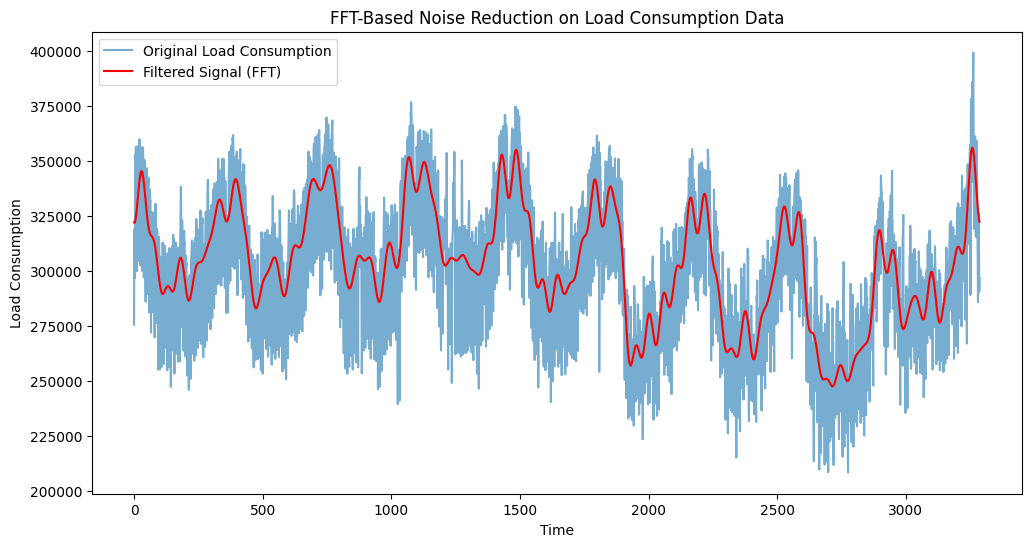

In [82]:
# Extract the target variable (loadConsumption)
load_series = FFT_data['loadConsumption'].values

# Apply FFT
fft_coeffs = np.fft.fft(load_series)
freqs = np.fft.fftfreq(len(load_series))

# Filter: Remove high-frequency noise (keep only dominant components)
threshold = 0.02  # Adjust this value to control noise filtering
fft_filtered = fft_coeffs.copy()
fft_filtered[np.abs(freqs) > threshold] = 0

# Reconstruct signal using Inverse FFT (IFFT)
filtered_signal = np.fft.ifft(fft_filtered).real

# Plot Original vs Filtered Signal
plt.figure(figsize=(12, 6))
plt.plot(load_series, label="Original Load Consumption", alpha=0.6)
plt.plot(filtered_signal, label="Filtered Signal (FFT)", color='red')
plt.title("FFT-Based Noise Reduction on Load Consumption Data")
plt.xlabel("Time")
plt.ylabel("Load Consumption")
plt.legend()
plt.show()

# Add FFT-filtered data to dataframe
FFT_data['loadConsumption_FFT'] = filtered_signal

In [83]:
FFT_data[['loadConsumption', 'loadConsumption_FFT']]

,loadConsumption,loadConsumption_FFT
date,,
2015-01-01,275667.0000,322079.291180
2015-01-02,319026.0000,321925.930585
2015-01-03,313131.0000,321940.229484
2015-01-04,296832.0000,322119.080932
2015-01-05,350937.0000,322457.457102
...,...,...
2023-12-27,305610.2900,325330.436368
2023-12-28,326312.3400,324361.861966
2023-12-29,314575.3300,323546.610755


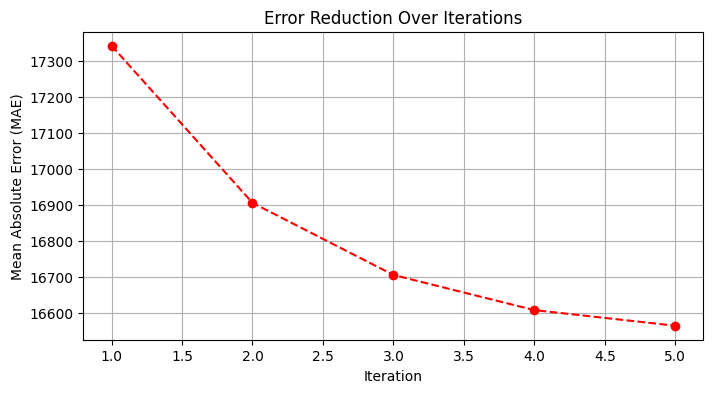

In [85]:
# Define the number of iterations for error compensation
num_iterations = 5

# Initialize the input series with FFT-filtered values
compensated_series = FFT_data['loadConsumption_FFT'].copy()

# Store error history
error_history = []

# Iteratively adjust the series based on errors
for i in range(num_iterations):
    # Predict using a simple moving average as a baseline model
    predicted = compensated_series.rolling(window=7, min_periods=1).mean()
    
    # Compute residual error (actual - predicted)
    error = FFT_data['loadConsumption'] - predicted
    
    # Store error history for analysis
    error_history.append(error.abs().mean())
    
    # Adjust the input series using a fraction of the error
    compensation_factor = 0.5  # Adjust how much of the error is compensated per step
    compensated_series += compensation_factor * error

# Plot convergence of the error
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_iterations + 1), error_history, marker='o', linestyle='--', color='red')
plt.xlabel("Iteration")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Error Reduction Over Iterations")
plt.grid(True)
plt.show()

# Add the iteratively compensated series to the dataframe
FFT_data['loadConsumption_Compensated'] = compensated_series


In [87]:
FFT_data[['loadConsumption', 'loadConsumption_FFT', 'loadConsumption_Compensated']]

,loadConsumption,loadConsumption_FFT,loadConsumption_Compensated
date,,,
2015-01-01,275667.0000,322079.291180,277117.384099
2015-01-02,319026.0000,321925.930585,343220.403021
2015-01-03,313131.0000,321940.229484,321011.034329
2015-01-04,296832.0000,322119.080932,286181.635859
2015-01-05,350937.0000,322457.457102,400334.534088
...,...,...,...
2023-12-27,305610.2900,325330.436368,310536.600277
2023-12-28,326312.3400,324361.861966,364940.402978
2023-12-29,314575.3300,323546.610755,338816.735428


Epoch 1/100
82/82 [==============================] - 28s 128ms/step - loss: 0.0582 - mae: 0.1900 - val_loss: 0.0306 - val_mae: 0.1530
Epoch 2/100
82/82 [==============================] - 7s 83ms/step - loss: 0.0313 - mae: 0.1467 - val_loss: 0.0248 - val_mae: 0.1347
Epoch 3/100
82/82 [==============================] - 9s 114ms/step - loss: 0.0198 - mae: 0.1139 - val_loss: 0.0178 - val_mae: 0.1075
Epoch 4/100
82/82 [==============================] - 8s 100ms/step - loss: 0.0113 - mae: 0.0833 - val_loss: 0.0163 - val_mae: 0.1026
Epoch 5/100
82/82 [==============================] - 7s 85ms/step - loss: 0.0099 - mae: 0.0776 - val_loss: 0.0206 - val_mae: 0.1193
Epoch 6/100
82/82 [==============================] - 10s 125ms/step - loss: 0.0086 - mae: 0.0698 - val_loss: 0.0200 - val_mae: 0.1172
Epoch 7/100
82/82 [==============================] - 7s 89ms/step - loss: 0.0077 - mae: 0.0656 - val_loss: 0.0146 - val_mae: 0.0984
Epoch 8/100
82/82 [==============================] - 8s 103ms/step - l

C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 4s 30ms/step
R² Score: 0.5084
MAPE: 92583152040700.34%
RMSE: 0.1258


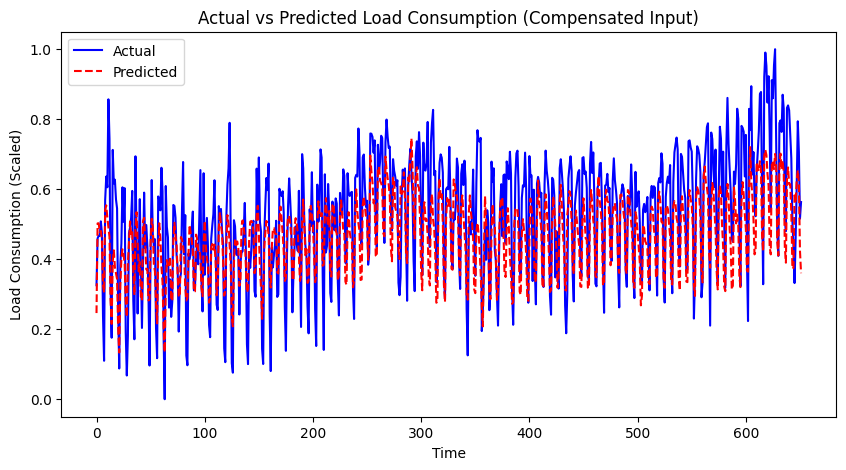

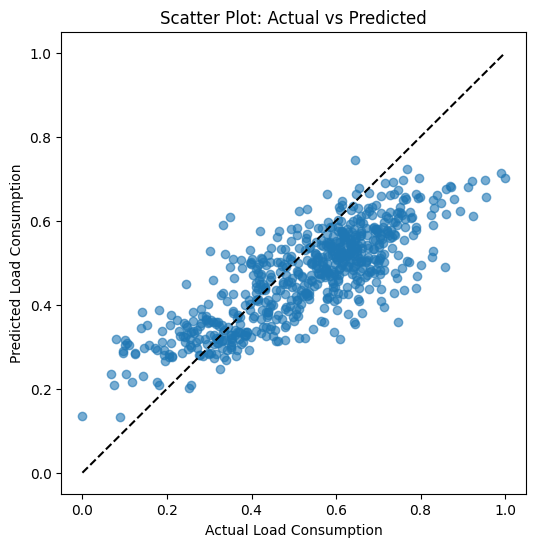

In [88]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Bidirectional, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt


FFT_data['loadConsumption_Final'] = FFT_data['loadConsumption_Compensated']

# Normalize the data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(FFT_data), columns=FFT_data.columns)

# Create Time Series Sequences
def create_sequences(data, target_column, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length].values)
        y.append(data.iloc[i+sequence_length][target_column])
    return np.array(X), np.array(y)

# Define Parameters
sequence_length = 30  # Using past 30 days for prediction
target_column = 'loadConsumption_Final'

# Prepare Data
X, y = create_sequences(df_scaled, target_column, sequence_length)
split = int(0.8 * len(X))  # 80% train, 20% validation
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# Build the DB-Net Model
def build_db_net(input_shape):
    inputs = Input(shape=input_shape)

    # Dilated CNN Feature Extraction
    x = Conv1D(filters=32, kernel_size=3, dilation_rate=1, activation='relu', padding='causal')(inputs)
    x = Conv1D(filters=32, kernel_size=3, dilation_rate=2, activation='relu', padding='causal')(x)

    # Bidirectional LSTM for Sequence Learning
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)

    # Fully Connected Layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)  # Regression Output

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

# Train the Model
model = build_db_net(input_shape=(sequence_length, X_train.shape[2]))
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

# Save Model
model.save("db_net_energy_forecasting_compensated.h5")

# ---------------- Evaluation ----------------
# Predict on Validation Set
y_pred = model.predict(X_val)

# Compute Evaluation Metrics
r2 = r2_score(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred) * 100  # Convert to percentage
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Print Metrics
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.4f}")

# Plot Actual vs Predicted Values
plt.figure(figsize=(10, 5))
plt.plot(y_val, label="Actual", color='blue')
plt.plot(y_pred, label="Predicted", color='red', linestyle='dashed')
plt.title("Actual vs Predicted Load Consumption (Compensated Input)")
plt.xlabel("Time")
plt.ylabel("Load Consumption (Scaled)")
plt.legend()
plt.show()

# Scatter Plot for Better Comparison
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="black", linestyle="dashed")  # 45-degree line
plt.xlabel("Actual Load Consumption")
plt.ylabel("Predicted Load Consumption")
plt.title("Scatter Plot: Actual vs Predicted")
plt.show()


In [95]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Bidirectional, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
import matplotlib.pyplot as plt


FFT_data['loadConsumption_Final'] = FFT_data['loadConsumption_Compensated']

# Normalize the data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(FFT_data), columns=FFT_data.columns)

# Create Time Series Sequences
def create_sequences(data, target_column, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length].values)
        y.append(data.iloc[i+sequence_length][target_column])
    return np.array(X), np.array(y)

# Define Parameters
sequence_length = 60  # Using past 30 days for prediction
target_column = 'loadConsumption_Final'

# Prepare Data
X, y = create_sequences(df_scaled, target_column, sequence_length)
split = int(0.8 * len(X))  # 80% train, 20% validation
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# Build the DB-Net Model
from tensorflow.keras.layers import BatchNormalization

def build_db_net(input_shape):
    inputs = Input(shape=input_shape)

    # **1️⃣ CNN Feature Extraction (with Batch Normalization)**
    x = Conv1D(filters=64, kernel_size=5, dilation_rate=1, activation='relu', padding='causal')(inputs)
    x = BatchNormalization()(x)  # Helps normalize activations and stabilize training
    x = Conv1D(filters=64, kernel_size=5, dilation_rate=1, activation='relu', padding='causal')(x)
    x = BatchNormalization()(x)

    # **2️⃣ BiLSTM for Sequential Learning (with Dropout)**
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3))(x)
    x = Bidirectional(LSTM(128, return_sequences=False, dropout=0.3))(x)

    # **3️⃣ Fully Connected Layers**
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)  # Extra dropout to reduce overfitting
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)  # Regression Output

    # **Compile Model**
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
    
    return model


# Train the Model
model = build_db_net(input_shape=(sequence_length, X_train.shape[2]))
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

# Save Model
model.save("db_net_energy_forecasting_compensated.h5")

# ---------------- Evaluation ----------------
# Predict on Validation Set
y_pred = model.predict(X_val)

# Compute Evaluation Metrics
r2 = r2_score(y_val, y_pred)
epsilon = 1e-5  # Prevents division by zero
mape_corrected = np.mean(np.abs((y_val_original - y_pred_original) / (y_val_original + epsilon))) * 100
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Print Metrics
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.4f}")

# Plot Actual vs Predicted Values
plt.figure(figsize=(10, 5))
plt.plot(y_val, label="Actual", color='blue')
plt.plot(y_pred, label="Predicted", color='red', linestyle='dashed')
plt.title("Actual vs Predicted Load Consumption (Compensated Input)")
plt.xlabel("Time")
plt.ylabel("Load Consumption (Scaled)")
plt.legend()
plt.show()

# Scatter Plot for Better Comparison
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="black", linestyle="dashed")  # 45-degree line
plt.xlabel("Actual Load Consumption")
plt.ylabel("Predicted Load Consumption")
plt.title("Scatter Plot: Actual vs Predicted")
plt.show()


Epoch 1/100
81/81 [==============================] - 37s 359ms/step - loss: 0.0604 - mae: 0.1922 - val_loss: 0.2156 - val_mae: 0.4314
Epoch 2/100
81/81 [==============================] - 28s 341ms/step - loss: 0.0246 - mae: 0.1265 - val_loss: 0.1563 - val_mae: 0.3594
Epoch 3/100
81/81 [==============================] - 27s 335ms/step - loss: 0.0199 - mae: 0.1126 - val_loss: 0.0740 - val_mae: 0.2332
Epoch 4/100
81/81 [==============================] - 27s 329ms/step - loss: 0.0178 - mae: 0.1054 - val_loss: 0.0244 - val_mae: 0.1232
Epoch 5/100
81/81 [==============================] - 28s 351ms/step - loss: 0.0152 - mae: 0.0974 - val_loss: 0.0212 - val_mae: 0.1193
Epoch 6/100
81/81 [==============================] - 28s 340ms/step - loss: 0.0144 - mae: 0.0937 - val_loss: 0.0206 - val_mae: 0.1155
Epoch 7/100
81/81 [==============================] - 29s 354ms/step - loss: 0.0131 - mae: 0.0903 - val_loss: 0.0244 - val_mae: 0.1274
Epoch 8/100
81/81 [==============================] - 27s 335ms

C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - 3s 65ms/step


NameError: name 'y_pred_original' is not defined

R² Score: 0.4766
MAPE: 203893329445753.50%
RMSE: 0.1303


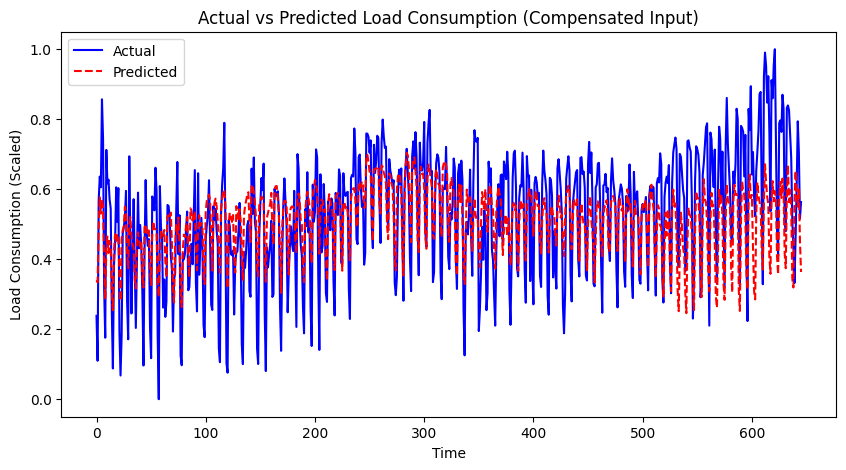

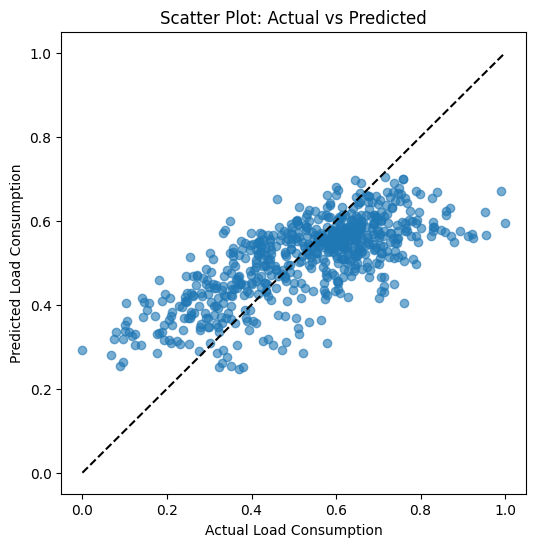

In [96]:
# Compute Evaluation Metrics
r2 = r2_score(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred) * 100  # Convert to percentage
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

# Print Metrics
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.4f}")

# Plot Actual vs Predicted Values
plt.figure(figsize=(10, 5))
plt.plot(y_val, label="Actual", color='blue')
plt.plot(y_pred, label="Predicted", color='red', linestyle='dashed')
plt.title("Actual vs Predicted Load Consumption (Compensated Input)")
plt.xlabel("Time")
plt.ylabel("Load Consumption (Scaled)")
plt.legend()
plt.show()

# Scatter Plot for Better Comparison
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="black", linestyle="dashed")  # 45-degree line
plt.xlabel("Actual Load Consumption")
plt.ylabel("Predicted Load Consumption")
plt.title("Scatter Plot: Actual vs Predicted")
plt.show()


In [97]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=200,  # Reduce from 500 to 200
    learning_rate=0.05, 
    max_depth=5,  # Reduce depth from 6 to 5
    subsample=0.7,  # Reduce subsampling for speed
    colsample_bytree=0.7, 
    random_state=42
)
xgb_model.fit(X_train, y_train)


ValueError: Please reshape the input data into 2-dimensional matrix.

In [98]:
FFT_data['loadConsumption_Final'] = FFT_data['loadConsumption_Compensated']

In [99]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

def create_sequences(data, target_column, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i : i + sequence_length].values)
        y.append(data.iloc[i + sequence_length][target_column])
    return np.array(X), np.array(y)

def build_db_net(input_shape):
    inputs = Input(shape=input_shape)

    # 1️⃣ CNN Feature Extraction
    x = Conv1D(filters=64, kernel_size=5, dilation_rate=1, activation='relu', padding='causal')(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(filters=64, kernel_size=5, dilation_rate=1, activation='relu', padding='causal')(x)
    x = BatchNormalization()(x)

    # 2️⃣ BiLSTM for Sequential Learning
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3))(x)
    x = Bidirectional(LSTM(128, return_sequences=False, dropout=0.3))(x)

    # 3️⃣ Fully Connected Layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
    return model

In [100]:
# Parameters for your time series
sequence_length = 60  # e.g., using past 60 time steps
split_fraction = 0.8  # 80% train, 20% validation/test
target_column = 'loadConsumption_Final'

results_list = []

for fs_name, fs_columns in feature_sets.items():
    print(f"\n=== Training DB-Net on: {fs_name} ===")

    # 1) Subset the DataFrame
    #    We combine the feature columns with the target column to scale them together
    subset_cols = fs_columns + [target_column]
    df_subset = FFT_data[subset_cols].copy()

    # 2) Scale the subset
    scaler = MinMaxScaler()
    # fit_transform the entire subset
    df_scaled = pd.DataFrame(scaler.fit_transform(df_subset), columns=subset_cols, index=df_subset.index)

    # 3) Create time-series sequences
    X_all, y_all = create_sequences(df_scaled, target_column, sequence_length)

    # 4) Split into train & validation
    split_index = int(len(X_all) * split_fraction)
    X_train, X_val = X_all[:split_index], X_all[split_index:]
    y_train, y_val = y_all[:split_index], y_all[split_index:]

    # Edge case: check if we have enough data
    if len(X_train) == 0 or len(X_val) == 0:
        print("Not enough data after sequence creation. Skipping this feature set.")
        results_list.append({
            'Feature Set': fs_name,
            'R^2':  None,
            'RMSE': None,
            'MAPE': None
        })
        continue

    # 5) Build the DB-Net model
    #    input_shape = (sequence_length, num_features)
    num_features = len(fs_columns)  # the target column is not part of X
    model = build_db_net((sequence_length, num_features))

    # 6) Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        verbose=1
    )

    # 7) Predict on validation set
    y_pred = model.predict(X_val).ravel()

    # 8) Compute metrics in scaled space
    r2 = r2_score(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    # If you want MAPE in scaled space:
    epsilon = 1e-5
    mape_scaled = np.mean(np.abs((y_val - y_pred) / (y_val + epsilon))) * 100

    # 9) Store results
    results_list.append({
        'Feature Set': fs_name,
        'R^2':  r2,
        'RMSE': rmse,
        'MAPE': mape_scaled
    })

    # 10) (Optional) Save the model
    #model.save(f"db_net_energy_forecasting_compensated_{fs_name}.h5")

    # (Optional) If you want to visualize y_val vs. y_pred for this feature set:
    plt.figure(figsize=(10,4))
    plt.plot(y_val, label="Actual", color='blue')
    plt.plot(y_pred, label="Predicted", color='red', linestyle='dashed')
    plt.title(f"DB-Net Predictions ({fs_name})")
    plt.legend()
    plt.show()

# Convert results to a DataFrame
results_df = pd.DataFrame(results_list)
print("\n=== Results Across Feature Sets ===")
print(results_df)



=== Training DB-Net on: Exogenous Features ===
Epoch 1/100


ValueError: in user code:

    File "C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 60, 10), found shape=(None, 60, 11)
